In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rosbag
import pymap3d as pm
import numba as nb

from scipy.signal import savgol_filter
%matplotlib inline

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
def rms(x):
    return np.sqrt(np.mean(np.square(x)))

In [3]:
def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

@nb.njit()
def to_euler(x, y, z, w):
    """Dari Coursera: Return as xyz (roll pitch yaw) Euler angles."""
    roll = np.arctan2(2 * (w * x + y * z), 1 - 2 * (x**2 + y**2))
    pitch = np.arcsin(2 * (w * y - z * x))
    yaw = np.arctan2(2 * (w * z + x * y), 1 - 2 * (y**2 + z**2))
    return np.array([roll, pitch, yaw])
# Compile the to_euler
_ = to_euler(1.5352300785980803e-15, -1.3393747145983517e-15, -0.7692164172827881, 0.638988343698562)

In [4]:
ls

 Archived/   bag/   img/  'Parameter PID.txt'   plot_data.ipynb


# DATA

In [5]:
bag = rosbag.Bag('bag/PID_3.bag')
# print(bag)

## Control Data

In [6]:
cs_t = []
cs_action_throttle = []
cs_action_steer = []
cs_error_lateral = []
cs_error_yaw = []
cs_error_speed = []
cs_actual_x = []
cs_actual_y = []
cs_actual_yaw = []
cs_actual_speed = []
cs_ref_x = []
cs_ref_y = []
cs_ref_yaw = []
cs_ref_curvature = []
cs_ref_speed = []
cs_wp_idx = []
for topic, msg, _ in bag.read_messages(topics=['/control_signal']):
    cs_t.append(msg.header.stamp.to_sec())
    cs_action_throttle.append(msg.action_throttle)
    cs_action_steer.append(msg.action_steer)
    cs_error_lateral.append(msg.error_lateral)
    cs_error_yaw.append(msg.error_yaw)
    cs_error_speed.append(msg.error_speed)
    cs_actual_x.append(msg.actual_x)
    cs_actual_y.append(msg.actual_y)
    cs_actual_yaw.append(msg.actual_yaw)
    cs_actual_speed.append(msg.actual_speed)
    cs_ref_x.append(msg.ref_x)
    cs_ref_y.append(msg.ref_y)
    cs_ref_yaw.append(msg.ref_yaw)
    cs_ref_curvature.append(msg.ref_curvature)
    cs_ref_speed.append(msg.ref_speed)
    cs_wp_idx.append(msg.wp_idx)
cs_t = np.array(cs_t)
cs_action_throttle = np.array(cs_action_throttle)
cs_action_steer = np.array(cs_action_steer)
cs_error_lateral = np.array(cs_error_lateral)
cs_error_yaw = np.array(cs_error_yaw)
cs_actual_x = np.array(cs_actual_x)
cs_actual_y = np.array(cs_actual_y)
cs_actual_yaw = np.array(cs_actual_yaw)
cs_actual_speed = np.array(cs_actual_speed)
cs_ref_x = np.array(cs_ref_x)
cs_ref_y = np.array(cs_ref_y)
cs_ref_yaw = np.array(cs_ref_yaw)
cs_ref_curvature = np.array(cs_ref_curvature)
cs_wp_idx = np.array(cs_wp_idx)

In [7]:
a_t = []
a_steering_setpoint = []
a_steering_angle = []
a_throttle_voltage = []
for topic, msg, _ in bag.read_messages(topics=['/logging_arduino']):
    a_t.append(msg.header.stamp.to_sec())
    a_steering_setpoint.append(msg.steering_setpoint )
    a_steering_angle.append(msg.steering_angle)
    a_throttle_voltage.append(msg.throttle_voltage)
a_t = np.array(a_t)
a_steering_setpoint = np.array(a_steering_setpoint)
a_steering_angle = np.array(a_steering_angle)
a_throttle_voltage = np.array(a_throttle_voltage)

## GNSS

In [8]:
lat0, lon0, h0 = -6.8712, 107.5738, 768
gnss_t = []
gnss_pos = []
gnss_cov = []
for topic, msg, _ in bag.read_messages(topics=['/fix']):
    gnss_t.append(msg.header.stamp.to_sec())
    gnss_pos.append(pm.geodetic2enu(msg.latitude, msg.longitude, msg.altitude, lat0, lon0, h0))
    gnss_cov.append(msg.position_covariance)
gnss_t = np.array(gnss_t)
gnss_pos = np.array(gnss_pos)
gnss_cov = np.array(gnss_cov).reshape(-1,3,3)

# Ambil sb. x & sb. y saja
gnss_x = np.copy(gnss_pos)[:,0]
gnss_y = np.copy(gnss_pos)[:,1]

## EKF Estimation

In [9]:
e_t = []
e_x = []
e_y = []
e_v = []
e_yaw = []
e_ba = []
e_bw = []
e_bc = []
e_bg = []
for topic, msg, _ in bag.read_messages(topics=['/state_2d']):
    e_t.append(msg.header.stamp.to_sec())
    e_x.append(msg.px)
    e_y.append(msg.py)
    e_v.append(np.sqrt(msg.vx**2 + msg.vy**2))
    e_yaw.append(msg.yaw)
    e_ba.append([msg.bax, msg.bay])
    e_bw.append(msg.bw)
    e_bc.append(msg.bc)
    e_bg.append([msg.bgx, msg.bgy])
e_t = np.array(e_t)
e_x = np.array(e_x)
e_y = np.array(e_y)
e_v = np.array(e_v)
e_yaw = np.array(e_yaw)
e_ba = np.array(e_ba)
e_bw = np.array(e_bw)
e_bc = np.array(e_bc)
e_bg = np.array(e_bg)

## Cek EKF Estimation

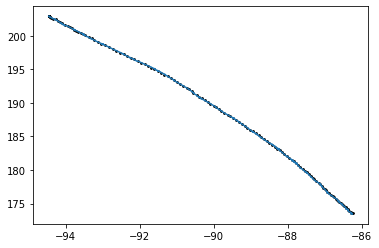

In [10]:
plt.plot(e_x, e_y)
plt.scatter(gnss_x, gnss_y, s=3., color='black')
# plt.xlim(-92, -90)
# plt.ylim(192,194)

# PLOT HASIL

## Longitudinal

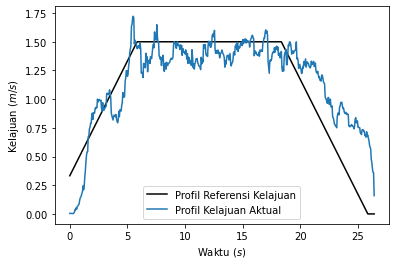

In [11]:
plt.plot(cs_t - cs_t[0], cs_ref_speed, label='Profil Referensi Kelajuan', color='black')
plt.plot(cs_t - cs_t[0], cs_actual_speed, label='Profil Kelajuan Aktual')
plt.legend()
plt.xlabel(r"Waktu $(s)$")
plt.ylabel(r"Kelajuan $(m/s)$")
plt.savefig("img/speed_kelajuan", dpi=500, transparent=True)
plt.show()

In [12]:
print('RMSE Error Speed: {:.4f} m/s'.format(rms(cs_error_speed)))

RMSE Error Speed: 0.2596 m/s


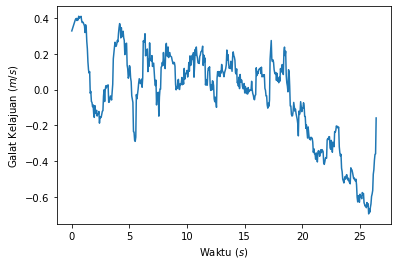

In [13]:
plt.plot(cs_t - cs_t[0], cs_error_speed)
plt.xlabel(r"Waktu $(s)$")
plt.ylabel(r"Galat Kelajuan $(m/s)$")
plt.savefig("img/speed_galat", dpi=500, transparent=True)
plt.show()

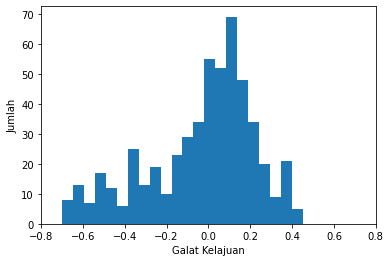

In [14]:
bin_list = list(np.linspace(-0.75, 0.45, num=24))
# plt.hist(cs_error_speed)
plt.hist(cs_error_speed, bins=bin_list)
plt.xlim(-0.8, 0.8)
plt.xlabel("Galat Kelajuan")
plt.ylabel("Jumlah")
plt.savefig("img/speed_histogram_galat", dpi=500, transparent=True)
plt.show()

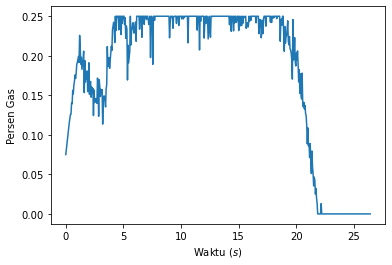

In [15]:
plt.plot(cs_t - cs_t[0], cs_action_throttle)
plt.xlabel(r"Waktu $(s)$")
plt.ylabel(r"Persen Gas")
plt.savefig("img/speed_gas", dpi=500, transparent=True)
plt.show()